# Notebook 9 — Two-Way DKL: Joint Race × Income Segregation

The **2-way DKL** extends the one-way metric by measuring how unevenly *joint*
(race, income) groups are distributed across census tracts within a metropolitan area.

## Formula

For each tract *i* and (race=*j*, income=*k*) cell:

$$\text{DKL}_{2\text{-way}}(i) = \sum_{j,k} p_{yz,i} \log_2 \frac{p_{yz,i}}{p_{yz}}$$

where $p_{yz,i} = P(\text{race}=j, \text{income}=k \mid \text{tract}=i)$ and
$p_{yz} = P(\text{race}=j, \text{income}=k)$ in the MSA.

## Decomposition

$$\text{Residual}(i) = \text{DKL}_{2\text{-way}}(i) - \text{DKL}_{\text{race}}(i) - \text{DKL}_{\text{income}}(i)$$

The residual captures sorting specific to particular *race × income* combinations —
beyond what either race or income sorting alone predicts.

## Data sources

| Year | Source | Tables |
|------|--------|--------|
| 2000 | Decennial Census SF3 | P151A–I (household income × race, 1999 dollars) |
| 2010 | ACS 5-year | B19001A–H |
| 2015 | ACS 5-year | B19001A–H |
| 2020 | ACS 5-year | B19001A–H |

Income brackets are identical across all four years (16 brackets, $0–$200K+).
2000 values are in **1999 dollars**; no inflation adjustment is applied — the
DKL metric is invariant to bracket labelling so cross-year comparison remains valid.

**Geography**: Census tract level (cross-tabulations not available at block group level).  
**Cities**: Atlanta, Chicago, Houston, New York

In [1]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from census import Census

warnings.filterwarnings('ignore')

NOTEBOOK_DIR = Path().resolve()
PIPELINE_DIR = NOTEBOOK_DIR.parent
if str(PIPELINE_DIR) not in sys.path:
    sys.path.insert(0, str(PIPELINE_DIR))

from config import DATA_DIR, CENSUS_API_KEY, CITIES
from utils.cbsa_xwalk import get_cbsa_xwalk

sns.set_theme(style='whitegrid', font_scale=0.95)
YEARS = [2000, 2010, 2015, 2020]

print(f'DATA_DIR : {DATA_DIR}')
print(f'CITIES   : {CITIES}')
print(f'YEARS    : {YEARS}')


DATA_DIR : /Users/bettencourt/Desktop/dkl-metric/pipeline/data
CITIES   : ['Chicago-Naperville-Elgin, IL-IN-WI', 'Houston-The Woodlands-Sugar Land, TX', 'Atlanta-Sandy Springs-Alpharetta, GA', 'New York-Newark-Jersey City, NY-NJ-PA']
YEARS    : [2000, 2010, 2015, 2020]


In [2]:
# ── Config ────────────────────────────────────────────────────────────────────

# ACS tables B19001A-I: household income by race/ethnicity
RACE_TABLES = {
    'White (non-Hisp.)': 'B19001H',
    'Black':             'B19001B',
    'Native American':   'B19001C',
    'Asian':             'B19001D',
    'Pacific Islander':  'B19001E',
    'Other race':        'B19001F',
    'Two or more':       'B19001G',
    'Hispanic/Latino':   'B19001I',
}

INCOME_ITEMS = [f'{i:03d}' for i in range(2, 18)]   # 002–017 (excludes total)

INCOME_LABELS = {
    '002': '< $10K',    '003': '$10–15K',  '004': '$15–20K',  '005': '$20–25K',
    '006': '$25–30K',   '007': '$30–35K',  '008': '$35–40K',  '009': '$40–45K',
    '010': '$45–50K',   '011': '$50–60K',  '012': '$60–75K',  '013': '$75–100K',
    '014': '$100–125K', '015': '$125–150K','016': '$150–200K','017': '> $200K',
}

RACE_COLORS = {
    'White (non-Hisp.)': '#4393c3',
    'Black':             '#d6604d',
    'Hispanic/Latino':   '#74c476',
    'Asian':             '#fd8d3c',
    'Two or more':       '#9e9ac8',
    'Native American':   '#bdbdbd',
    'Pacific Islander':  '#a1d99b',
    'Other race':        '#bcbddc',
}

CITY_SHORT = {c: c.split(',')[0].split('-')[0].strip() for c in CITIES}
print('City labels:', list(CITY_SHORT.values()))

City labels: ['Chicago', 'Houston', 'Atlanta', 'New York']


In [3]:
# ── CBSA crosswalk → identify states needed ───────────────────────────────────

cbsa_xwalk = get_cbsa_xwalk(2020)

primary_names = [c.split(',')[0] for c in CITIES]
city_counties = cbsa_xwalk[
    cbsa_xwalk['cbsa_title'].str.contains('|'.join(primary_names), case=False, na=False)
].copy()

study_state_fips = sorted(city_counties['county_fips'].str[:2].unique().tolist())
print(f'States to download ({len(study_state_fips)}): {study_state_fips}')
print(city_counties.groupby('cbsa_title').size().rename('n_counties'))

States to download (8): ['13', '17', '18', '34', '36', '42', '48', '55']
cbsa_title
Atlanta-Sandy Springs-Alpharetta, GA     29
Chicago-Naperville-Elgin, IL-IN-WI       14
Houston-The Woodlands-Sugar Land, TX      9
New York-Newark-Jersey City, NY-NJ-PA    23
Name: n_counties, dtype: int64


In [4]:
# ── Download B19001A-H (ACS 2010-2020) or P151A-H (2000 SF3) at tract level ───
#
# ACS 5-year tables B19001A–H:  household income by race/ethnicity
#   Variable format: {TABLE}_{ITEM}E  (e.g. B19001H_002E)
#   Years: 2010, 2015, 2020
#
# 2000 Decennial Census SF3 tables P151A–I: household income by race/ethnicity
#   Variable format: {TABLE}{ITEM}  (e.g. P151I002, no underscore, no E suffix)
#   Same 16 income brackets as ACS B19001 (values in 1999 dollars)
#   Race letter mapping: A=White (all), B=Black, C=AIAN, D=Asian, E=NHPI,
#   F=Other, G=Two+, H=Hispanic, I=White non-Hispanic
#   → White non-Hispanic = P151I (matches ACS B19001H)
#   → Hispanic           = P151H (matches ACS B19001I)
#
# Note: the `census` Python package does not expose an sf3 dataset object.
# 2000 SF3 data is fetched via direct requests to the Census API.
# Endpoint: https://api.census.gov/data/2000/dec/sf3

import requests as _requests

# 2000 SF3 race → table prefix (letter suffix matches ACS B19001 convention)
SF3_RACE_TABLES_2000 = {
    'White (non-Hisp.)': 'P151I',   # White alone, not Hispanic or Latino
    'Black':             'P151B',
    'Native American':   'P151C',
    'Asian':             'P151D',
    'Pacific Islander':  'P151E',
    'Other race':        'P151F',
    'Two or more':       'P151G',
    'Hispanic/Latino':   'P151H',
}

_SF3_2000_URL = 'https://api.census.gov/data/2000/dec/sf3'


def _build_acs_variables():
    """ACS B19001A-H variable base codes (without E suffix)."""
    return [
        f'{table}_{item}'
        for table in RACE_TABLES.values()
        for item in INCOME_ITEMS
    ]


def _build_sf3_2000_variables():
    """2000 SF3 P151A-H variable codes (no underscore, no E suffix)."""
    return [
        f'{table}{item}'          # e.g. 'P151I002'
        for table in SF3_RACE_TABLES_2000.values()
        for item in INCOME_ITEMS
    ]


def _fetch_state_acs(c_api, state_fips, year):
    """Fetch ACS B19001A-H tract data for one state; returns (df, variables)."""
    variables = _build_acs_variables()
    chunk_size = 45
    chunks = [variables[i:i+chunk_size] for i in range(0, len(variables), chunk_size)]
    dfs = []
    for chunk in chunks:
        api_vars = [v + 'E' for v in chunk]
        rows = c_api.acs5.state_county_tract(
            fields=['NAME'] + api_vars,
            state_fips=state_fips,
            county_fips=Census.ALL,
            tract=Census.ALL,
            year=year,
        )
        df = pd.DataFrame(rows)
        df = df.rename(columns={v + 'E': v for v in chunk})
        dfs.append(df)

    result = dfs[0]
    for extra in dfs[1:]:
        shared = [c for c in extra.columns if c in result.columns and c not in variables]
        result = result.merge(
            extra[shared + [v for v in extra.columns if v in variables]],
            on=shared, how='left'
        )
    result['tract_fips'] = (
        result['state'].astype(str).str.zfill(2) +
        result['county'].astype(str).str.zfill(3) +
        result['tract'].astype(str).str.zfill(6)
    )
    return result, variables


def _fetch_state_sf3_2000(state_fips, api_key):
    """Fetch 2000 SF3 P151A-H tract data via direct Census API; returns (df, variables)."""
    variables = _build_sf3_2000_variables()
    chunk_size = 45   # Census API limit per request
    chunks = [variables[i:i+chunk_size] for i in range(0, len(variables), chunk_size)]
    dfs = []
    for chunk in chunks:
        params = {
            'get':  'NAME,' + ','.join(chunk),
            'for':  'tract:*',
            'in':   f'state:{state_fips}+county:*',
            'key':  api_key,
        }
        resp = _requests.get(_SF3_2000_URL, params=params, timeout=120)
        resp.raise_for_status()
        rows = resp.json()
        header, data = rows[0], rows[1:]
        df = pd.DataFrame(data, columns=header)
        dfs.append(df)

    result = dfs[0]
    for extra in dfs[1:]:
        shared = [c for c in extra.columns if c in result.columns and c not in variables]
        result = result.merge(
            extra[shared + [v for v in extra.columns if v in variables]],
            on=shared, how='left'
        )
    result['tract_fips'] = (
        result['state'].astype(str).str.zfill(2) +
        result['county'].astype(str).str.zfill(3) +
        result['tract'].astype(str).str.zfill(6)
    )
    return result, variables


def _to_long(df, variables, year):
    """Melt wide tract df to long format; parse race_group and income_item."""
    long = df[['tract_fips'] + [v for v in variables if v in df.columns]].melt(
        id_vars=['tract_fips'], var_name='variable', value_name='estimate'
    )
    if year == 2000:
        # P151I002 → race='White (non-Hisp.)', income_item='002'
        long['race_group']  = long['variable'].apply(
            lambda v: next(k for k, t in SF3_RACE_TABLES_2000.items() if v.startswith(t))
        )
    else:
        # B19001H_002 → race='White (non-Hisp.)', income_item='002'
        long['race_group']  = long['variable'].apply(
            lambda v: next(k for k, t in RACE_TABLES.items() if t == v[:7])
        )
    long['income_item']  = long['variable'].str[-3:]
    long['income_label'] = long['income_item'].map(INCOME_LABELS)
    return long[['tract_fips', 'race_group', 'income_item', 'income_label', 'estimate']]


def download_joint_data(year, state_fips_list, api_key):
    c_api = Census(api_key)
    frames = []
    for sf in state_fips_list:
        print(f'  State {sf} …', end=' ', flush=True)
        try:
            if year == 2000:
                df, variables = _fetch_state_sf3_2000(sf, api_key)
            else:
                df, variables = _fetch_state_acs(c_api, sf, year)

            for v in variables:
                if v in df.columns:
                    df[v] = pd.to_numeric(df[v], errors='coerce').fillna(0).clip(lower=0)
                else:
                    df[v] = 0.0

            frames.append(_to_long(df, variables, year))
            print(f'{len(df):,} tracts')
        except Exception as e:
            print(f'ERROR: {e}')
    return pd.concat(frames, ignore_index=True)


# Download / load each year, then combine
frames_by_year = {}
for year in YEARS:
    cache = DATA_DIR / 'two_way_dkl' / f'joint_race_income_tract_{year}.parquet'
    cache.parent.mkdir(parents=True, exist_ok=True)
    if cache.exists():
        print(f'Year {year}: loading from cache …')
        frames_by_year[year] = pd.read_parquet(cache)
    else:
        print(f'Year {year}: downloading …')
        df = download_joint_data(year, study_state_fips, CENSUS_API_KEY)
        df.to_parquet(cache, index=False)
        frames_by_year[year] = df
    print(f'  {len(frames_by_year[year]):,} rows')

joint_raw_all = pd.concat(
    [df.assign(year=yr) for yr, df in frames_by_year.items()],
    ignore_index=True
)
print(f'\nCombined: {len(joint_raw_all):,} rows')
joint_raw_all.head(3)


Year 2000: loading from cache …


  2,779,008 rows
Year 2010: downloading …
  State 13 … 

1,969 tracts
  State 17 … 

3,123 tracts
  State 18 … 

1,511 tracts
  State 34 … 

2,010 tracts
  State 36 … 

4,919 tracts
  State 42 … 

3,218 tracts
  State 48 … 

5,265 tracts
  State 55 … 

1,409 tracts


  2,998,272 rows
Year 2015: loading from cache …
  2,998,144 rows
Year 2020: loading from cache …


  3,485,824 rows



Combined: 12,261,248 rows


tract_fips         race_group income_item income_label  estimate  year
0  13001009501  White (non-Hisp.)         002       < $10K     113.0  2000
1  13001009502  White (non-Hisp.)         002       < $10K      80.0  2000
2  13001009503  White (non-Hisp.)         002       < $10K     287.0  2000

In [5]:
# ── Filter to study cities + attach CBSA info ─────────────────────────────────

county_cbsa = cbsa_xwalk[['county_fips','cbsa_fips','cbsa_title']].drop_duplicates()

joint_all = joint_raw_all.copy()
joint_all['county_fips'] = joint_all['tract_fips'].str[:5]
joint_all = joint_all.merge(county_cbsa, on='county_fips', how='inner')

mask = joint_all['cbsa_title'].str.contains(
    '|'.join(primary_names), case=False, na=False
)
joint_all = joint_all[mask].copy()

def _city_label(title):
    for c in CITIES:
        if c.split(',')[0].lower() in title.lower():
            return CITY_SHORT[c]
    return title.split(',')[0]

joint_all['city_label'] = joint_all['cbsa_title'].apply(_city_label)

income_order = [INCOME_LABELS[k] for k in sorted(INCOME_LABELS)]
joint_all['income_label'] = pd.Categorical(joint_all['income_label'], categories=income_order, ordered=True)

# Working alias used throughout downstream cells
joint = joint_all

print(f'Filtered rows: {len(joint_all):,}')
print(joint_all.groupby(['year','city_label']).agg(tracts=('tract_fips','nunique')).to_string())

Filtered rows: 4,621,440


                 tracts
year city_label        
2000 Atlanta        695
     Chicago       2057
     Houston        891
     New York      4501
2010 Atlanta        951
     Chicago       2215
     Houston       1072
     New York      4543
2015 Atlanta        951
     Chicago       2215
     Houston       1072
     New York      4542
2020 Atlanta       1500
     Chicago       2335
     Houston       1606
     New York      4953


In [6]:
# ── Compute tract- and CBSA-level aggregations (year-aware) ───────────────────

joint['tract_joint']  = joint['estimate']
joint['tract_total']  = joint.groupby(['year','tract_fips'])['estimate'].transform('sum')
joint['tract_race']   = joint.groupby(['year','tract_fips','race_group'])['estimate'].transform('sum')
joint['tract_income'] = joint.groupby(['year','tract_fips','income_item'])['estimate'].transform('sum')

joint['cbsa_joint']   = joint.groupby(['year','cbsa_fips','race_group','income_item'])['estimate'].transform('sum')
joint['cbsa_total']   = joint.groupby(['year','cbsa_fips'])['estimate'].transform('sum')
joint['cbsa_race']    = joint.groupby(['year','cbsa_fips','race_group'])['estimate'].transform('sum')
joint['cbsa_income']  = joint.groupby(['year','cbsa_fips','income_item'])['estimate'].transform('sum')

print('Aggregations done. Sample:')
joint[['year','tract_fips','race_group','income_item','estimate','tract_total','cbsa_total']].head(5)

Aggregations done. Sample:


year   tract_fips         race_group income_item  estimate  tract_total  \
12  2000  13013180101  White (non-Hisp.)         002     132.0       3491.0   
13  2000  13013180102  White (non-Hisp.)         002      57.0       1734.0   
14  2000  13013180201  White (non-Hisp.)         002     219.0       2378.0   
15  2000  13013180202  White (non-Hisp.)         002     165.0       1691.0   
16  2000  13013001803  White (non-Hisp.)         002     165.0       2556.0   

    cbsa_total  
12   1592190.0  
13   1592190.0  
14   1592190.0  
15   1592190.0  
16   1592190.0

In [7]:
# ── Compute 2-way DKL and 1-way components (year-aware) ───────────────────────

def safe_log2(num, denom):
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where((num > 0) & (denom > 0), num / denom, np.nan)
        return np.where(np.isfinite(ratio) & (ratio > 0), np.log2(ratio), 0.0)


T  = joint['tract_total'].values
CT = joint['cbsa_total'].values

p_yjzk_ni = np.where(T > 0,  joint['tract_joint'].values  / T,  0.0)
p_yjzk    = np.where(CT > 0, joint['cbsa_joint'].values   / CT, 0.0)
p_yj_ni   = np.where(T > 0,  joint['tract_race'].values   / T,  0.0)
p_yj      = np.where(CT > 0, joint['cbsa_race'].values    / CT, 0.0)
p_zk_ni   = np.where(T > 0,  joint['tract_income'].values / T,  0.0)
p_zk      = np.where(CT > 0, joint['cbsa_income'].values  / CT, 0.0)

joint['dkl_2way_jk']  = p_yjzk_ni * safe_log2(p_yjzk_ni, p_yjzk)
joint['dkl_race_j']   = p_yj_ni   * safe_log2(p_yj_ni,   p_yj)
joint['dkl_income_k'] = p_zk_ni   * safe_log2(p_zk_ni,   p_zk)

# ── Aggregate to tract level ──
tract_dkl_all = (
    joint.groupby(['year','tract_fips','cbsa_fips','cbsa_title','city_label'])
    .agg(dkl_2way=('dkl_2way_jk','sum'), tract_total=('tract_total','first'))
    .reset_index()
)

race_1way = (
    joint.drop_duplicates(['year','tract_fips','race_group'])
    .groupby(['year','tract_fips'])['dkl_race_j'].sum()
    .rename('dkl_1way_race')
)
income_1way = (
    joint.drop_duplicates(['year','tract_fips','income_item'])
    .groupby(['year','tract_fips'])['dkl_income_k'].sum()
    .rename('dkl_1way_income')
)

tract_dkl_all = (
    tract_dkl_all
    .set_index(['year','tract_fips'])
    .join(race_1way)
    .join(income_1way)
    .reset_index()
)
tract_dkl_all['residual'] = (
    tract_dkl_all['dkl_2way']
    - tract_dkl_all['dkl_1way_race']
    - tract_dkl_all['dkl_1way_income']
)

# Convenience alias: 2020-only slice
tract_dkl = tract_dkl_all[tract_dkl_all['year'] == 2020].copy()

print(f'Tract-level DKL: {len(tract_dkl_all):,} rows | years: {sorted(tract_dkl_all["year"].unique())}')
tract_dkl_all.groupby(['year','city_label'])[
    ['dkl_2way','dkl_1way_race','dkl_1way_income','residual']
].median().round(4)

Tract-level DKL: 36,099 rows | years: [np.int64(2000), np.int64(2010), np.int64(2015), np.int64(2020)]


dkl_2way  dkl_1way_race  dkl_1way_income  residual
year city_label                                                    
2000 Atlanta       0.6711         0.3046           0.1806    0.1466
     Chicago       0.8376         0.4531           0.2105    0.1405
     Houston       0.7644         0.3544           0.2057    0.1588
     New York      0.9805         0.5271           0.2343    0.1810
2010 Atlanta       1.0097         0.3744           0.2684    0.2774
     Chicago       1.0583         0.4660           0.3101    0.2562
     Houston       1.1187         0.4046           0.3281    0.3218
     New York      1.2248         0.5664           0.3415    0.3203
2015 Atlanta       0.9893         0.3906           0.2572    0.2965
     Chicago       1.0013         0.4449           0.2738    0.2516
     Houston       1.0936         0.4081           0.3123    0.3278
     New York      1.1492         0.5609           0.2917    0.3097
2020 Atlanta       1.4099         0.4570           0.4474    0.4408
     Chicago       1.1445         0.4562           0.3360    0.3315
     Houston       1.5631         0.4627           0.4984    0.5256
     New York      1.3246         0.5603           0.3615    0.4089

In [8]:
# ── City-level summary: population-weighted means ─────────────────────────────

def weighted_mean(df, col, weight='tract_total'):
    w = df[weight].clip(lower=0)
    return (df[col] * w).sum() / w.sum() if w.sum() > 0 else np.nan

summary_all = (
    tract_dkl_all.groupby(['year','city_label'])
    .apply(lambda g: pd.Series({
        'DKL 2-way (joint race×income)': weighted_mean(g, 'dkl_2way'),
        'DKL 1-way race':               weighted_mean(g, 'dkl_1way_race'),
        'DKL 1-way income':             weighted_mean(g, 'dkl_1way_income'),
        'Residual (interaction)':       weighted_mean(g, 'residual'),
        'n_tracts':                     len(g),
    }))
    .reset_index()
)

# Convenience alias: 2020-only slice
summary = summary_all[summary_all['year'] == 2020].drop(columns='year').reset_index(drop=True)

print('Population-weighted mean DKL by city and year:')
summary_all.set_index(['year','city_label']).round(4)

Population-weighted mean DKL by city and year:


DKL 2-way (joint race×income)  DKL 1-way race  \
year city_label                                                  
2000 Atlanta                            0.7724          0.4174   
     Chicago                            1.0197          0.6460   
     Houston                            0.8483          0.4556   
     New York                           1.0768          0.6464   
2010 Atlanta                            1.0264          0.4508   
     Chicago                            1.2315          0.6424   
     Houston                            1.1264          0.4633   
     New York                           1.3230          0.6624   
2015 Atlanta                            1.0394          0.4468   
     Chicago                            1.1826          0.6247   
     Houston                            1.1227          0.4480   
     New York                           1.2711          0.6455   
2020 Atlanta                            1.4396          0.5179   
     Chicago                            1.3331          0.6262   
     Houston                            1.5731          0.5026   
     New York                           1.4413          0.6357   

                 DKL 1-way income  Residual (interaction)  n_tracts  
year city_label                                                      
2000 Atlanta               0.2299                  0.1250     695.0  
     Chicago               0.2520                  0.1216    2057.0  
     Houston               0.2642                  0.1286     891.0  
     New York              0.2886                  0.1418    4501.0  
2010 Atlanta               0.3012                  0.2743     951.0  
     Chicago               0.3378                  0.2513    2215.0  
     Houston               0.3668                  0.2963    1072.0  
     New York              0.3806                  0.2800    4543.0  
2015 Atlanta               0.2987                  0.2939     951.0  
     Chicago               0.3136                  0.2444    2215.0  
     Houston               0.3550                  0.3198    1072.0  
     New York              0.3505                  0.2752    4542.0  
2020 Atlanta               0.4749                  0.4467    1500.0  
     Chicago               0.3773                  0.3296    2335.0  
     Houston               0.5379                  0.5325    1606.0  
     New York              0.4218                  0.3838    4953.0

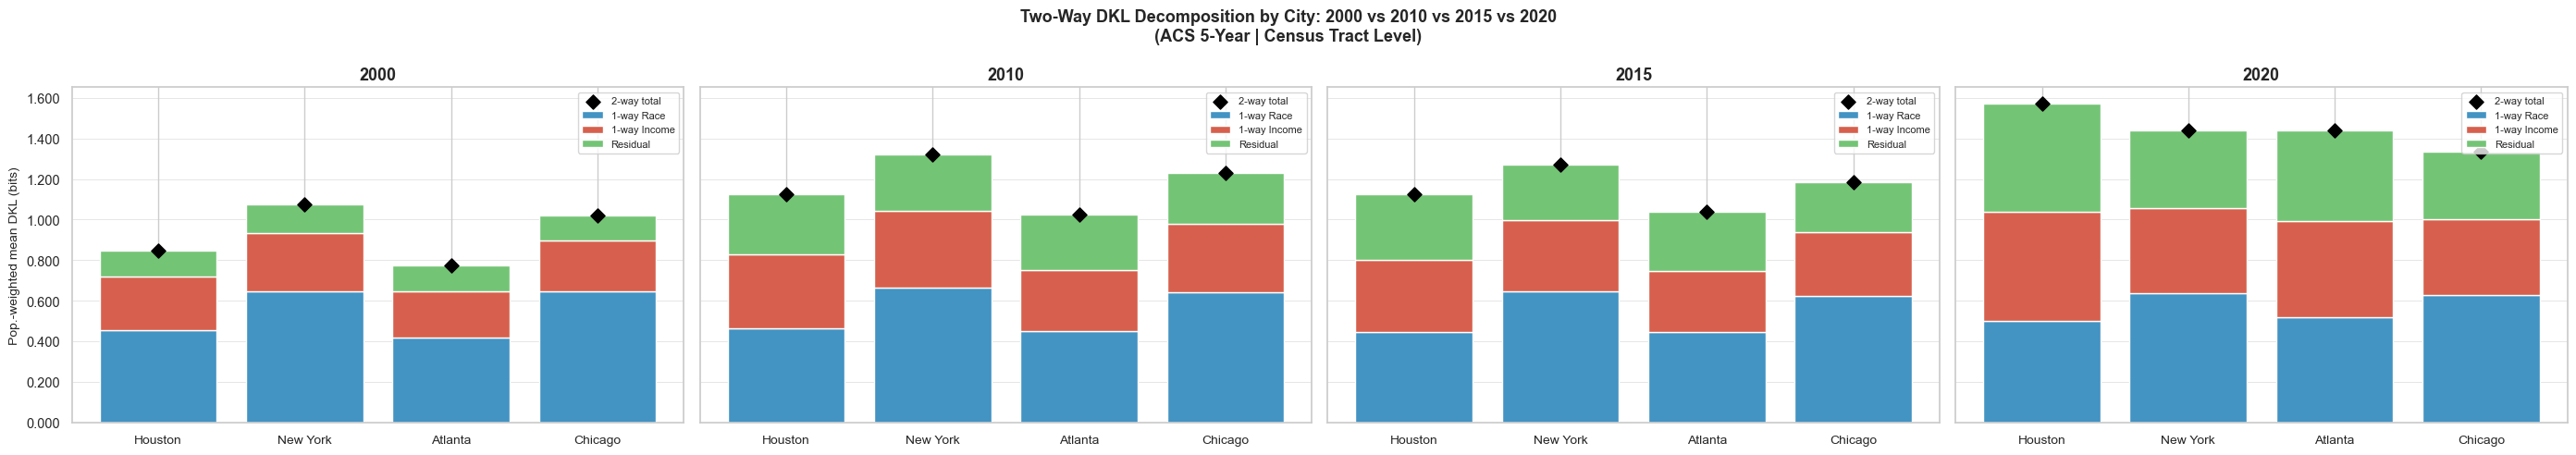

In [9]:
# ── Plot 1: City comparison — stacked bars per year ───────────────────────────

metric_cols   = ['DKL 1-way race', 'DKL 1-way income', 'Residual (interaction)']
metric_labels = ['1-way Race', '1-way Income', 'Residual']
colors        = ['#4393c3', '#d6604d', '#74c476']

# City order by most-recent year's 2-way DKL descending
city_order = (
    summary_all[summary_all['year'] == YEARS[-1]]
    .sort_values('DKL 2-way (joint race×income)', ascending=False)['city_label']
    .tolist()
)

fig, axes = plt.subplots(1, len(YEARS), figsize=(7 * len(YEARS), 5), sharey=True)
if len(YEARS) == 1:
    axes = [axes]

for ax, year in zip(axes, YEARS):
    sub = summary_all[summary_all['year'] == year].set_index('city_label')
    x = np.arange(len(city_order))
    bottom = np.zeros(len(city_order))
    for col, color, label in zip(metric_cols, colors, metric_labels):
        vals = np.array([sub.loc[c, col] if c in sub.index else 0 for c in city_order])
        ax.bar(x, vals, bottom=bottom, color=color, edgecolor='white', label=label)
        bottom += vals
    totals = [
        sub.loc[c, 'DKL 2-way (joint race×income)'] if c in sub.index else 0
        for c in city_order
    ]
    ax.scatter(x, totals, color='black', zorder=5, s=60, marker='D', label='2-way total')
    ax.set_xticks(x)
    ax.set_xticklabels(city_order, fontsize=10)
    ax.set_title(f'{year}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
    ax.grid(axis='y', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

axes[0].set_ylabel('Pop.-weighted mean DKL (bits)', fontsize=10)
year_str = ' vs '.join(str(y) for y in YEARS)
fig.suptitle(
    f'Two-Way DKL Decomposition by City: {year_str}\n'
    '(ACS 5-Year | Census Tract Level)',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

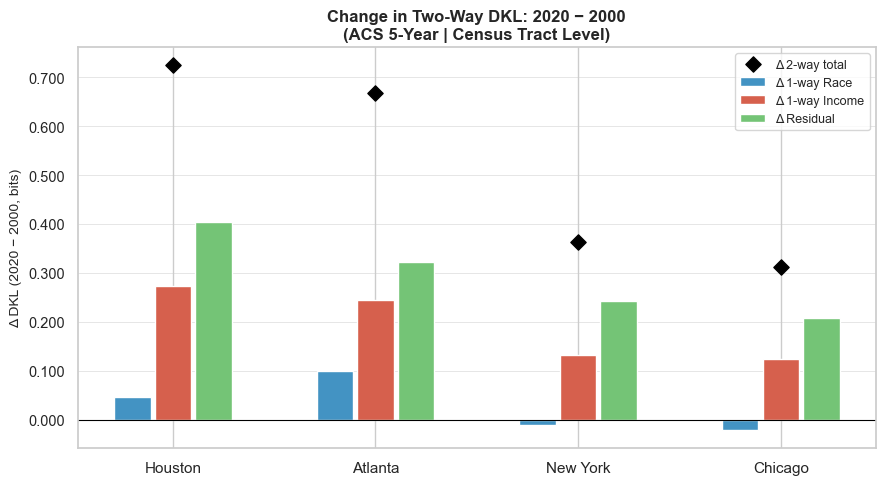

In [10]:
# ── Plot 2: Change in DKL — last year minus first year ────────────────────────

yr_first, yr_last = YEARS[0], YEARS[-1]
pivot_first = summary_all[summary_all['year'] == yr_first].set_index('city_label')
pivot_last  = summary_all[summary_all['year'] == yr_last].set_index('city_label')
common      = sorted(set(pivot_first.index) & set(pivot_last.index))
delta       = (pivot_last.loc[common] - pivot_first.loc[common]).drop(columns=['n_tracts'])

delta_order = delta.sort_values('DKL 2-way (joint race×income)', ascending=False).index.tolist()

fig, ax = plt.subplots(figsize=(9, 5))
x     = np.arange(len(delta_order))
bar_w = 0.2

for i, (col, color, label) in enumerate(zip(metric_cols, colors, metric_labels)):
    ax.bar(
        x + (i - 1) * bar_w,
        delta.loc[delta_order, col],
        width=bar_w * 0.9, color=color, label=f'Δ {label}', edgecolor='white'
    )

ax.scatter(
    x, delta.loc[delta_order, 'DKL 2-way (joint race×income)'],
    color='black', zorder=5, s=60, marker='D', label='Δ 2-way total'
)
ax.axhline(0, color='black', linewidth=0.8)

ax.set_xticks(x)
ax.set_xticklabels(delta_order, fontsize=11)
ax.set_ylabel(f'Δ DKL ({yr_last} − {yr_first}, bits)', fontsize=10)
ax.set_title(
    f'Change in Two-Way DKL: {yr_last} − {yr_first}\n(ACS 5-Year | Census Tract Level)',
    fontsize=12, fontweight='bold'
)
ax.legend(fontsize=9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
ax.grid(axis='y', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

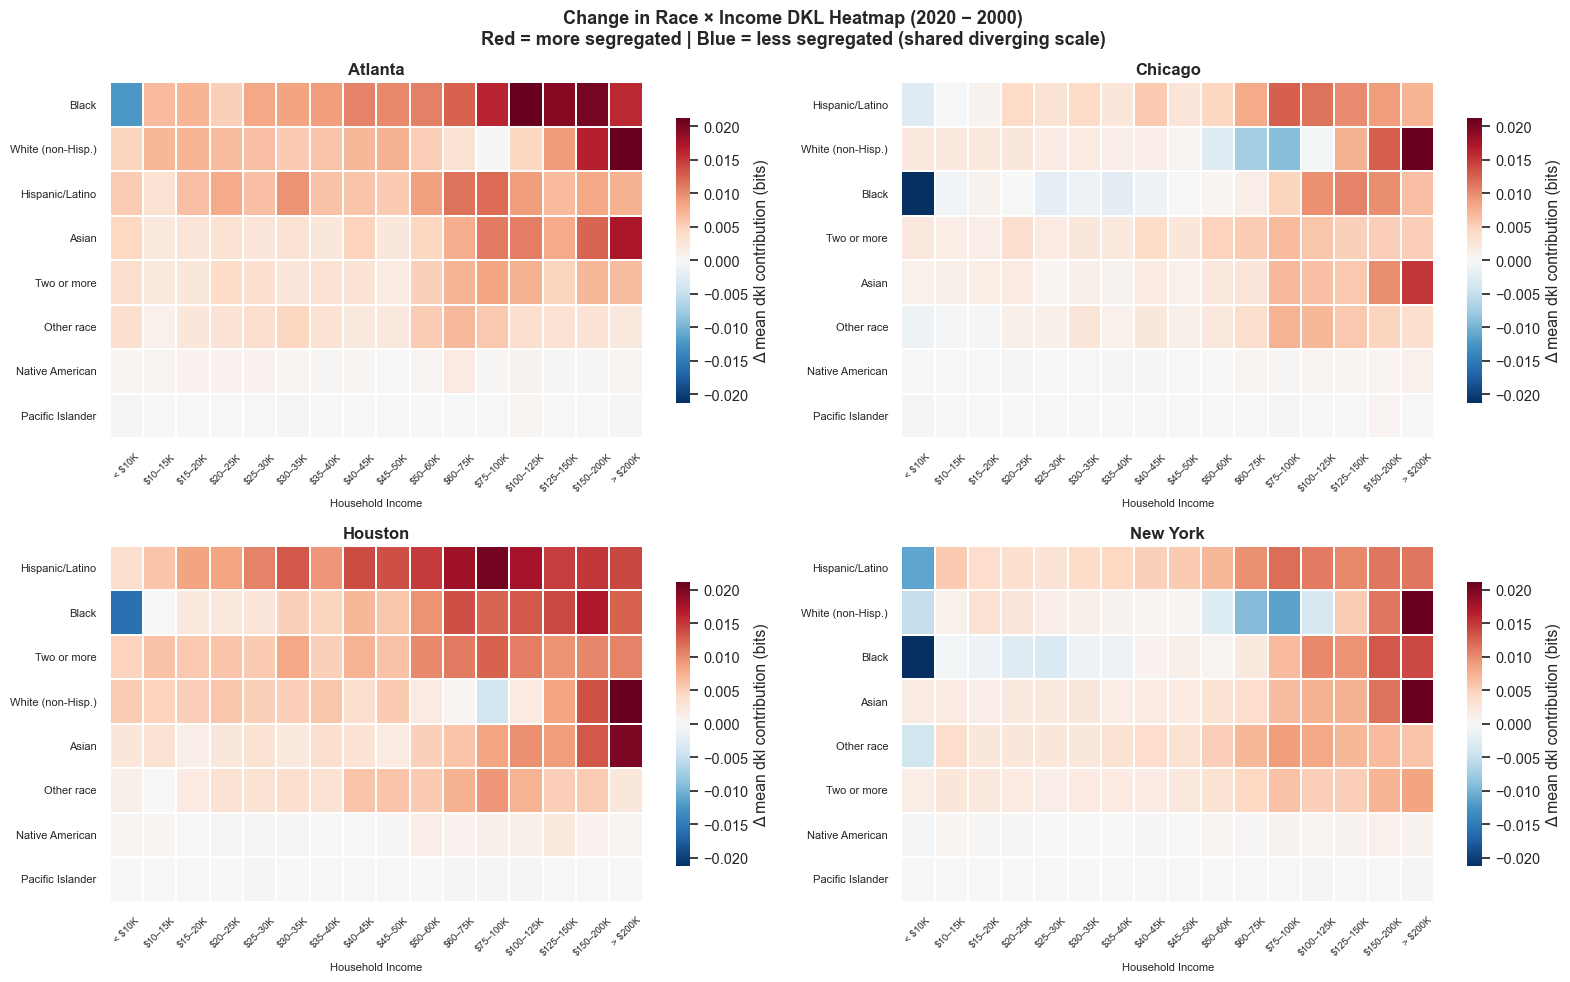

In [11]:
# ── Plot 3: Heatmap — change in race × income DKL matrix (last vs first year) ─
#
# For each (race, income) cell: pop.-weighted mean DKL contribution change.
# Red = more segregated in last year; Blue = less segregated.

def cell_dkl_matrix(city, year):
    sub = joint[(joint['city_label'] == city) & (joint['year'] == year)].copy()
    sub['w_dkl'] = sub['dkl_2way_jk'] * sub['tract_total']
    agg = (
        sub.groupby(['race_group','income_label'], observed=True)
        .agg(w_dkl=('w_dkl','sum'), w=('tract_total','sum'))
        .reset_index()
    )
    agg['mean_dkl'] = agg['w_dkl'] / agg['w'].replace(0, np.nan)
    return agg.pivot(index='race_group', columns='income_label', values='mean_dkl')


yr_first, yr_last = YEARS[0], YEARS[-1]
cities_list = sorted(joint['city_label'].unique())
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Shared diverging scale across all cities
all_deltas = []
for city in cities_list:
    m_first = cell_dkl_matrix(city, yr_first)
    m_last  = cell_dkl_matrix(city, yr_last)
    all_deltas.append((m_last - m_first).values.flatten())
bound = np.nanpercentile(np.concatenate(all_deltas), 99)

for ax, city in zip(axes.flat, cities_list):
    m_first = cell_dkl_matrix(city, yr_first)
    m_last  = cell_dkl_matrix(city, yr_last)
    delta_heat = (m_last - m_first).reindex_like(m_last)

    # Row order by absolute change
    race_order = delta_heat.abs().sum(axis=1).sort_values(ascending=False).index.tolist()
    delta_heat = delta_heat.loc[race_order]

    sns.heatmap(
        delta_heat, ax=ax,
        cmap='RdBu_r', center=0, vmin=-bound, vmax=bound,
        linewidths=0.3, linecolor='white',
        cbar_kws={'label': 'Δ mean dkl contribution (bits)', 'shrink': 0.8},
    )
    ax.set_title(city, fontsize=12, fontweight='bold')
    ax.set_xlabel('Household Income', fontsize=8)
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelrotation=45, labelsize=7)
    ax.tick_params(axis='y', labelrotation=0, labelsize=8)

fig.suptitle(
    f'Change in Race × Income DKL Heatmap ({yr_last} − {yr_first})\n'
    'Red = more segregated | Blue = less segregated (shared diverging scale)',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

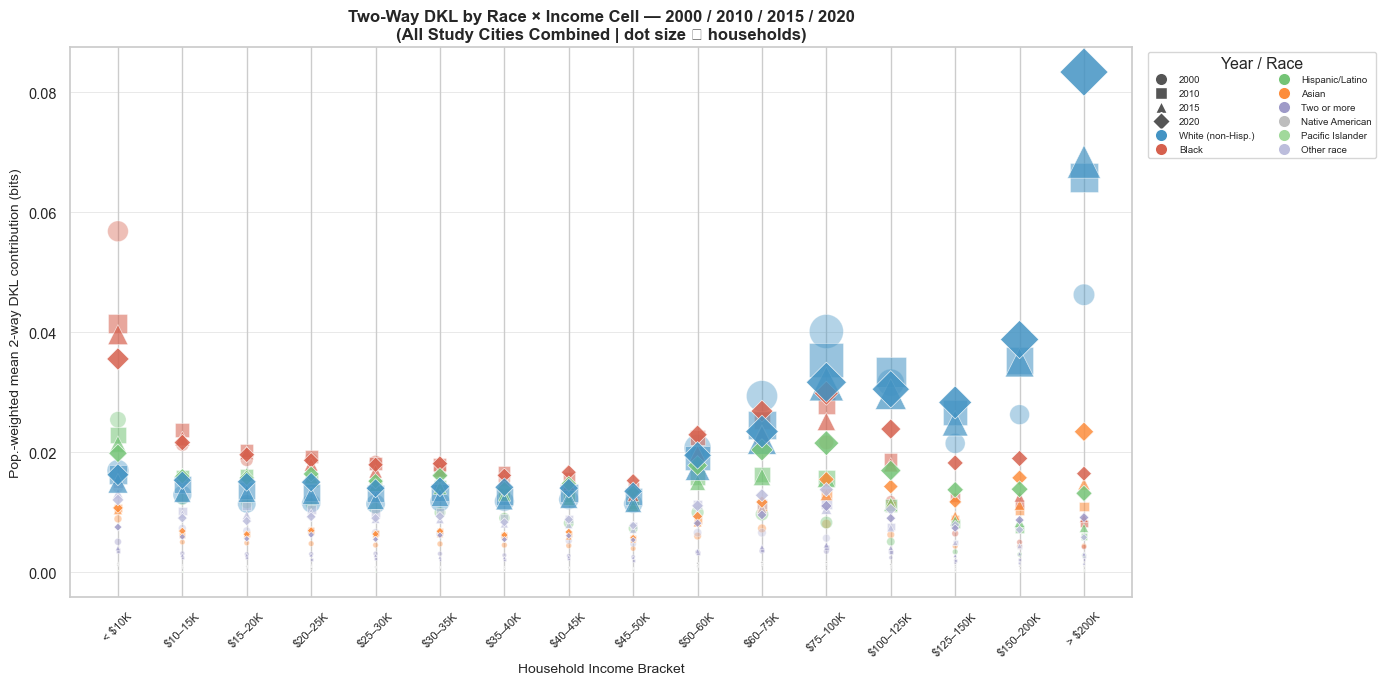

In [12]:
# ── Plot 4: Dot plot — 2-way DKL by (race, income) cell, all years ────────────
#
# Each year uses a distinct marker shape. Size ∝ households. Colour = race group.

_marker_seq = ['o', 's', '^', 'D', 'v']
_alpha_vals  = np.linspace(0.40, 0.85, len(YEARS))
year_markers = {yr: _marker_seq[i] for i, yr in enumerate(YEARS)}
year_alpha   = {yr: float(_alpha_vals[i]) for i, yr in enumerate(YEARS)}

fig, ax = plt.subplots(figsize=(14, 7))

for year in YEARS:
    dot_sub = joint[joint['year'] == year].copy()
    dot_sub['w_dkl_jk'] = dot_sub['dkl_2way_jk'] * dot_sub['tract_total']
    dot_agg = (
        dot_sub.groupby(['race_group','income_label'], observed=True)
        .agg(
            total_households=('estimate', 'sum'),
            w_dkl=('w_dkl_jk', 'sum'),
            w=('tract_total', 'sum'),
        )
        .reset_index()
    )
    dot_agg['mean_dkl'] = dot_agg['w_dkl'] / dot_agg['w'].replace(0, np.nan)
    dot_agg = dot_agg.dropna(subset=['mean_dkl'])
    max_hh = dot_agg['total_households'].max()

    for race, grp in dot_agg.groupby('race_group'):
        ax.scatter(
            grp['income_label'], grp['mean_dkl'],
            s=grp['total_households'] / max_hh * 600,
            color=RACE_COLORS.get(race, '#888'),
            alpha=year_alpha[year],
            edgecolors='white', linewidths=0.5, zorder=3,
            marker=year_markers[year],
        )

# Legend: year shapes + race colours
legend_els = [
    Line2D([0],[0], marker=year_markers[yr], color='w', markerfacecolor='#555',
           markersize=9, label=str(yr), markeredgecolor='white')
    for yr in YEARS
] + [
    Line2D([0],[0], marker='o', color='w', markerfacecolor=RACE_COLORS.get(r,'#888'),
           markersize=9, label=r, markeredgecolor='white')
    for r in RACE_COLORS
]
ax.legend(handles=legend_els, title='Year / Race', fontsize=7, ncol=2,
          bbox_to_anchor=(1.01, 1), loc='upper left')

ax.set_xlabel('Household Income Bracket', fontsize=10)
ax.set_ylabel('Pop.-weighted mean 2-way DKL contribution (bits)', fontsize=10)
year_str = ' / '.join(str(y) for y in YEARS)
ax.set_title(
    f'Two-Way DKL by Race × Income Cell — {year_str}\n'
    '(All Study Cities Combined | dot size ∝ households)',
    fontsize=12, fontweight='bold'
)
ax.tick_params(axis='x', labelrotation=45, labelsize=8)
ax.grid(axis='y', linewidth=0.5, alpha=0.6)
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

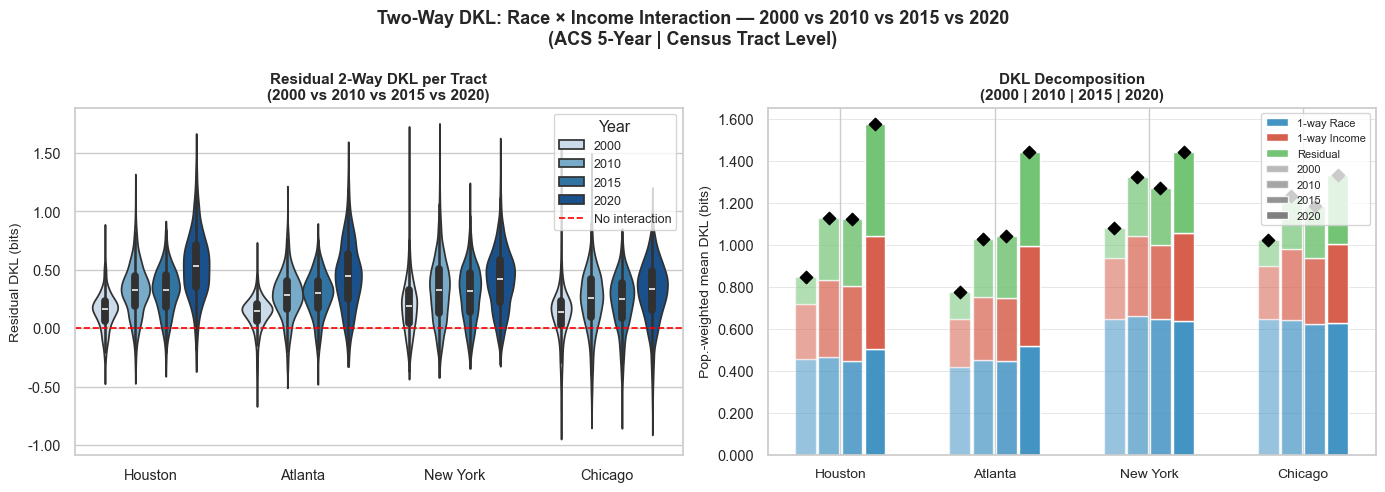

In [13]:
# ── Plot 5: Violin + stacked bars — all years ─────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Violin with year hue
ax = axes[0]
plot_data = tract_dkl_all[tract_dkl_all['tract_total'] > 50].copy()
plot_data['year_str'] = plot_data['year'].astype(str)
city_order_v = (
    plot_data[plot_data['year'] == YEARS[-1]]
    .groupby('city_label')['residual'].median()
    .sort_values(ascending=False).index.tolist()
)

# Blues from lightest (earliest) to darkest (latest)
_blue_shades = ['#c6dbef', '#6baed6', '#1f77b4', '#08519c', '#08306b']
violin_palette = {str(yr): _blue_shades[i] for i, yr in enumerate(YEARS)}

sns.violinplot(
    data=plot_data, x='city_label', y='residual', hue='year_str',
    order=city_order_v,
    palette=violin_palette,
    inner='box', ax=ax, cut=0,
)
ax.axhline(0, color='red', linestyle='--', linewidth=1.2, label='No interaction')
ax.set_xlabel('')
ax.set_ylabel('Residual DKL (bits)', fontsize=10)
year_str = ' vs '.join(str(y) for y in YEARS)
ax.set_title(f'Residual 2-Way DKL per Tract\n({year_str})', fontsize=11, fontweight='bold')
ax.legend(title='Year', fontsize=9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

# Panel B: Side-by-side stacked bars (one bar per year per city)
ax = axes[1]
n_years    = len(YEARS)
bar_w      = min(0.6 / n_years, 0.30)
offsets    = np.linspace(-(n_years - 1) / 2, (n_years - 1) / 2, n_years) * bar_w
alphas     = np.linspace(0.55, 1.0, n_years)
year_offset = dict(zip(YEARS, offsets))
year_alpha  = dict(zip(YEARS, alphas))
x = np.arange(len(city_order_v))

for year in YEARS:
    sub = summary_all[summary_all['year'] == year].set_index('city_label')
    bottom = np.zeros(len(city_order_v))
    for col, color in zip(metric_cols, colors):
        vals = np.array([sub.loc[c, col] if c in sub.index else 0 for c in city_order_v])
        ax.bar(x + year_offset[year], vals, width=bar_w * 0.9, bottom=bottom,
               color=color, alpha=float(year_alpha[year]), edgecolor='white')
        bottom += vals
    totals = [
        sub.loc[c, 'DKL 2-way (joint race×income)'] if c in sub.index else 0
        for c in city_order_v
    ]
    ax.scatter(x + year_offset[year], totals, color='black', zorder=5, s=40, marker='D')

ax.set_xticks(x)
ax.set_xticklabels(city_order_v, fontsize=10)
ax.set_ylabel('Pop.-weighted mean DKL (bits)', fontsize=10)
bar_legend = ' | '.join(str(yr) for yr in YEARS)
ax.set_title(f'DKL Decomposition\n({bar_legend})', fontsize=11, fontweight='bold')

legend_els = [Patch(facecolor=c, label=l) for c, l in zip(colors, metric_labels)]
legend_els += [
    Patch(facecolor='grey', alpha=float(alphas[i]), label=str(yr))
    for i, yr in enumerate(YEARS)
]
ax.legend(handles=legend_els, fontsize=8, loc='upper right')
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
ax.grid(axis='y', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

fig.suptitle(
    f'Two-Way DKL: Race × Income Interaction — {year_str}\n'
    '(ACS 5-Year | Census Tract Level)',
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.show()

In [14]:
# ── Choropleth: download tract shapefiles ─────────────────────────────────────
#
# Map each data year to the closest TIGER shapefile year.
# TIGER2010 uses a different URL layout and file-name convention (suffix '10'),
# so we use 2015 shapefiles for ACS 2010 data. Tract boundaries are stable
# between 2010 and 2015; the approximation is negligible for visualisation.
#
#   ACS 2010 → TIGER2015  |  ACS 2015 → TIGER2015  |  ACS 2020 → TIGER2020

import geopandas as gpd
import contextily as ctx
import requests

SHAPEFILE_CACHE = DATA_DIR / 'two_way_dkl'
SHAPEFILE_YEAR  = {yr: (2020 if yr >= 2020 else 2015) for yr in YEARS}


def download_tracts(state_fips, year, cache_base):
    sf        = str(state_fips).zfill(2)
    cache_dir = cache_base / f'tracts_{year}'
    cache_dir.mkdir(parents=True, exist_ok=True)
    fpath = cache_dir / f'tl_{year}_{sf}_tract.parquet'
    if fpath.exists():
        return gpd.read_parquet(fpath)
    url = (
        f'https://www2.census.gov/geo/tiger/TIGER{year}/TRACT/'
        f'tl_{year}_{sf}_tract.zip'
    )
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    zip_path = cache_dir / f'tl_{year}_{sf}_tract.zip'
    zip_path.write_bytes(r.content)
    try:
        gdf = gpd.read_file(f'zip://{zip_path}!tl_{year}_{sf}_tract.shp')
    finally:
        zip_path.unlink(missing_ok=True)
    gdf = gdf.rename(columns=str.lower)
    gdf['geoid'] = gdf['geoid'].str.zfill(11)
    gdf = gdf[['geoid', 'geometry']]
    gdf.to_parquet(fpath, index=False)
    return gdf


# Download only the unique shapefile years needed (avoids re-downloading 2015 twice)
tracts_by_sf_year = {}
for sf_year in sorted(set(SHAPEFILE_YEAR.values())):
    print(f'Downloading {sf_year} tract shapefiles …')
    gdfs = []
    for sf in study_state_fips:
        try:
            gdfs.append(download_tracts(sf, sf_year, SHAPEFILE_CACHE))
            print(f'  {sf} ✓', end='  ')
        except Exception as e:
            print(f'  {sf} ERROR: {e}')
    tracts_by_sf_year[sf_year] = gpd.GeoDataFrame(
        pd.concat(gdfs, ignore_index=True),
        geometry='geometry', crs='EPSG:4326'
    )
    print(f'\n  → {len(tracts_by_sf_year[sf_year]):,} tracts')

# Map each data year to its shapefile GeoDataFrame
tracts_by_year = {yr: tracts_by_sf_year[SHAPEFILE_YEAR[yr]] for yr in YEARS}
print('Shapefiles ready.')

  13 ✓    17 ✓    18 ✓    34 ✓    36 ✓    42 ✓    48 ✓  

  55 ✓  
  → 23,423 tracts
  13 ✓    17 ✓    18 ✓    34 ✓    36 ✓    42 ✓    48 ✓  

  55 ✓  
  → 27,233 tracts
Shapefiles ready.


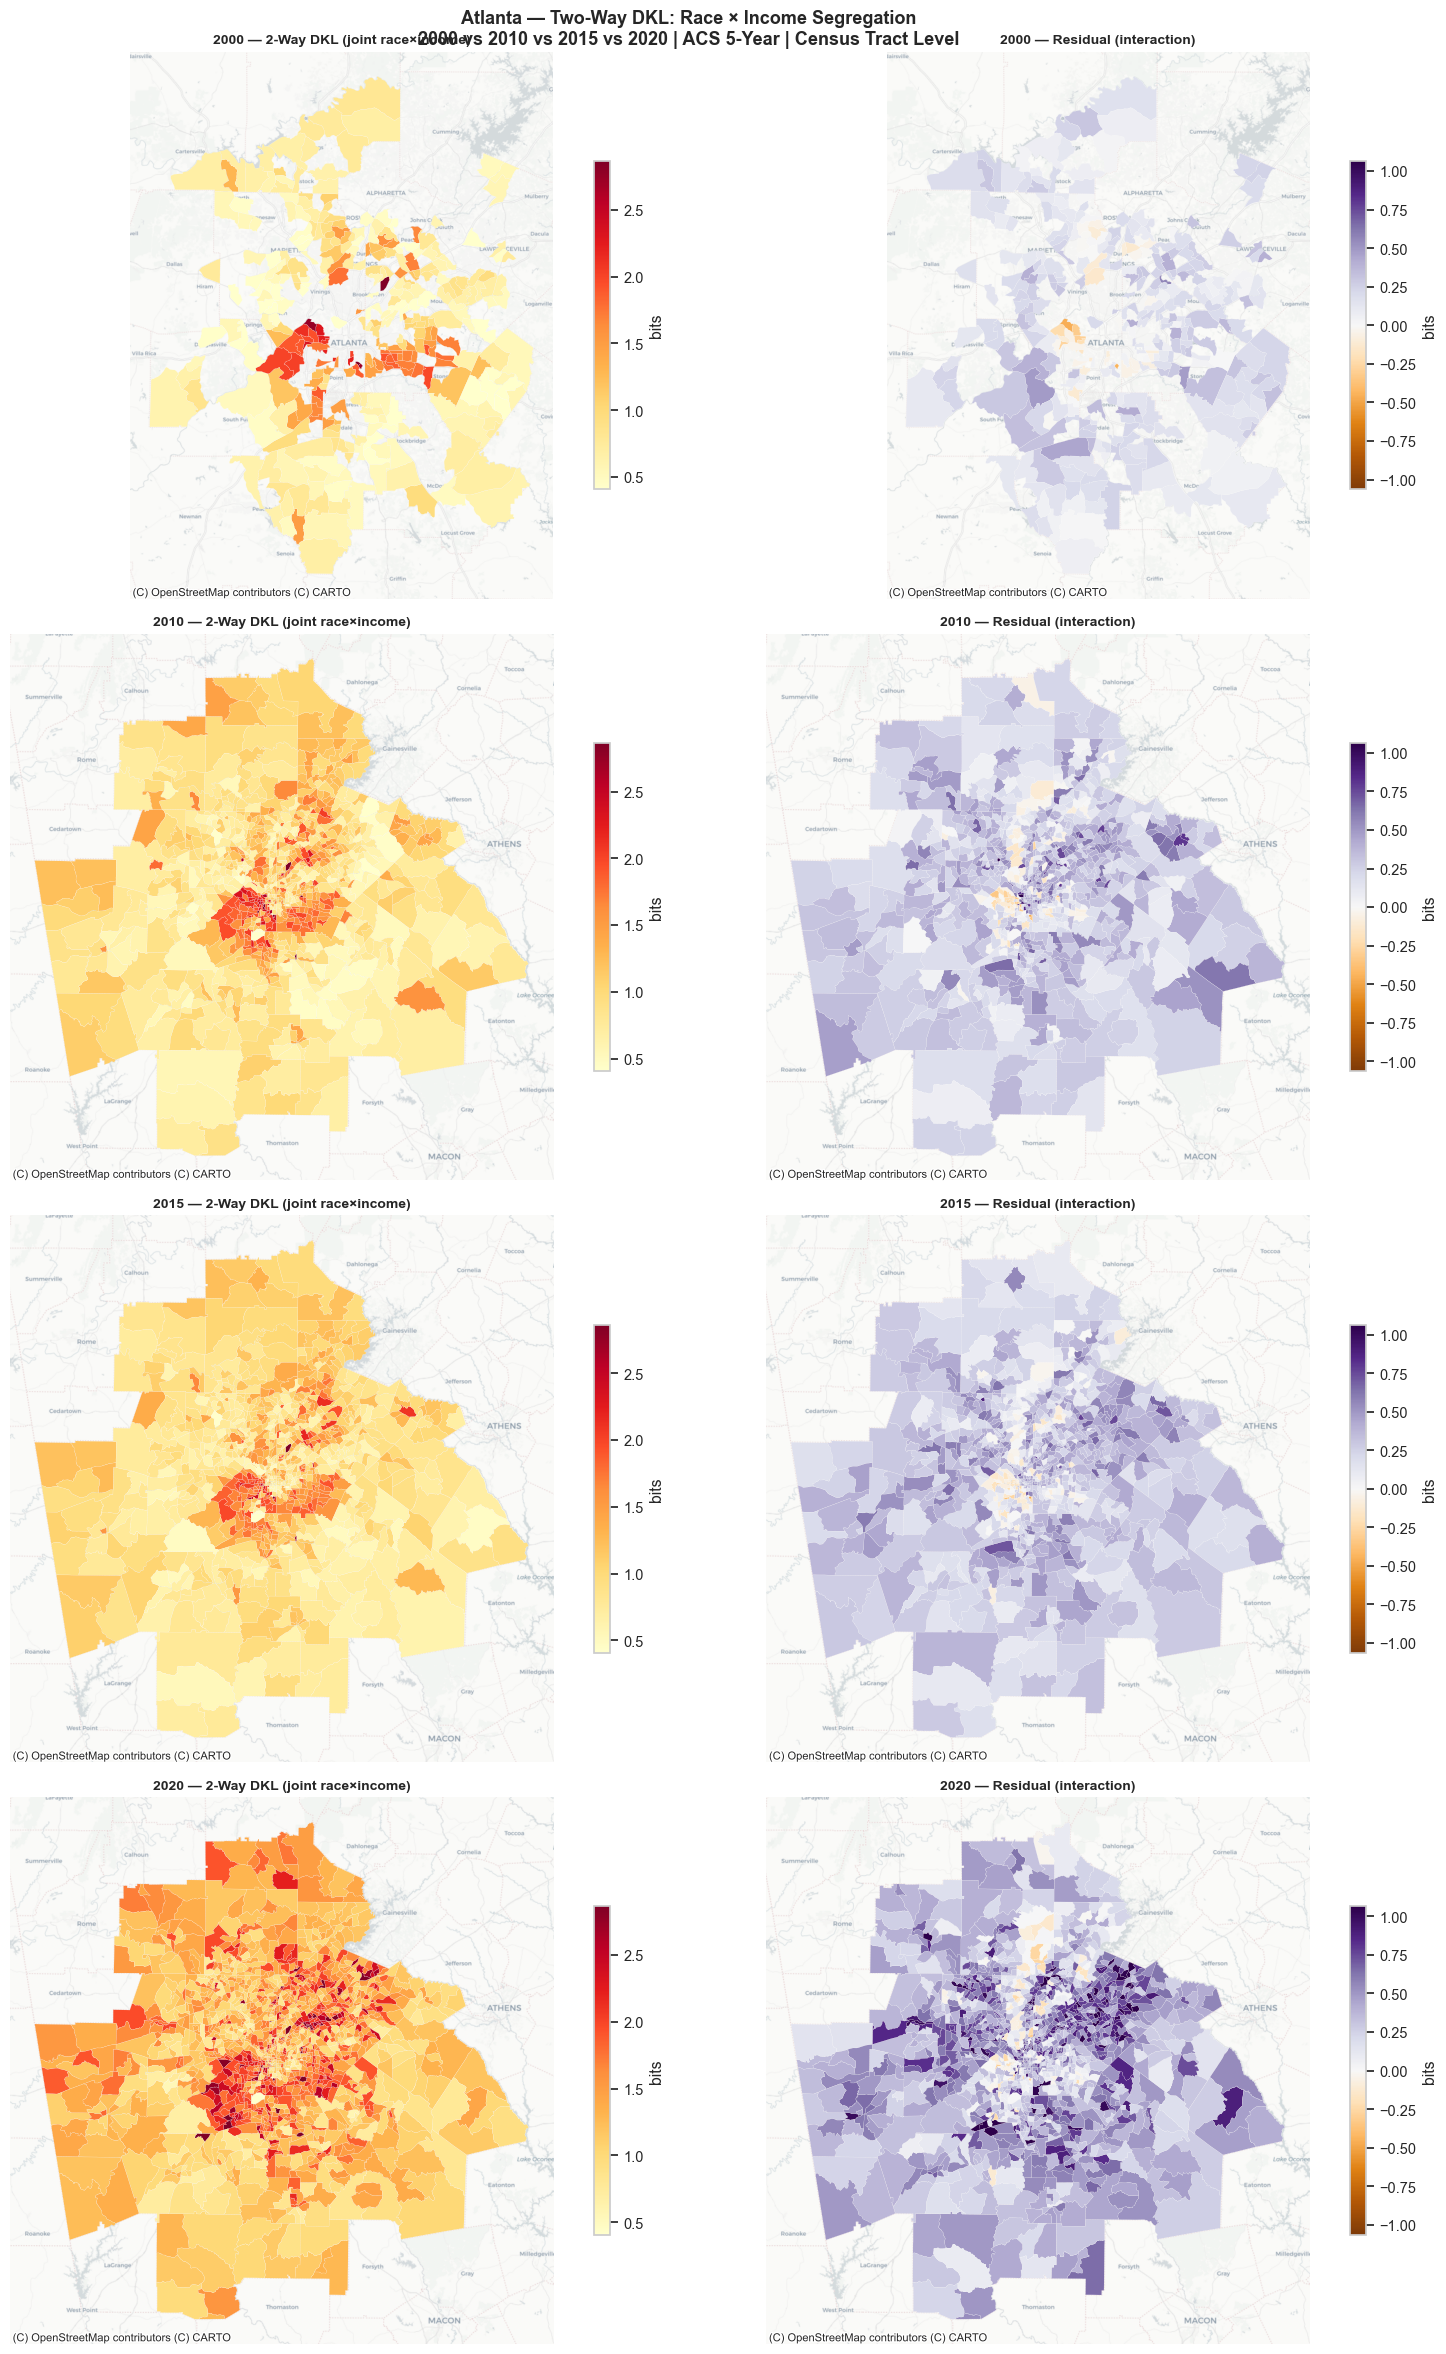

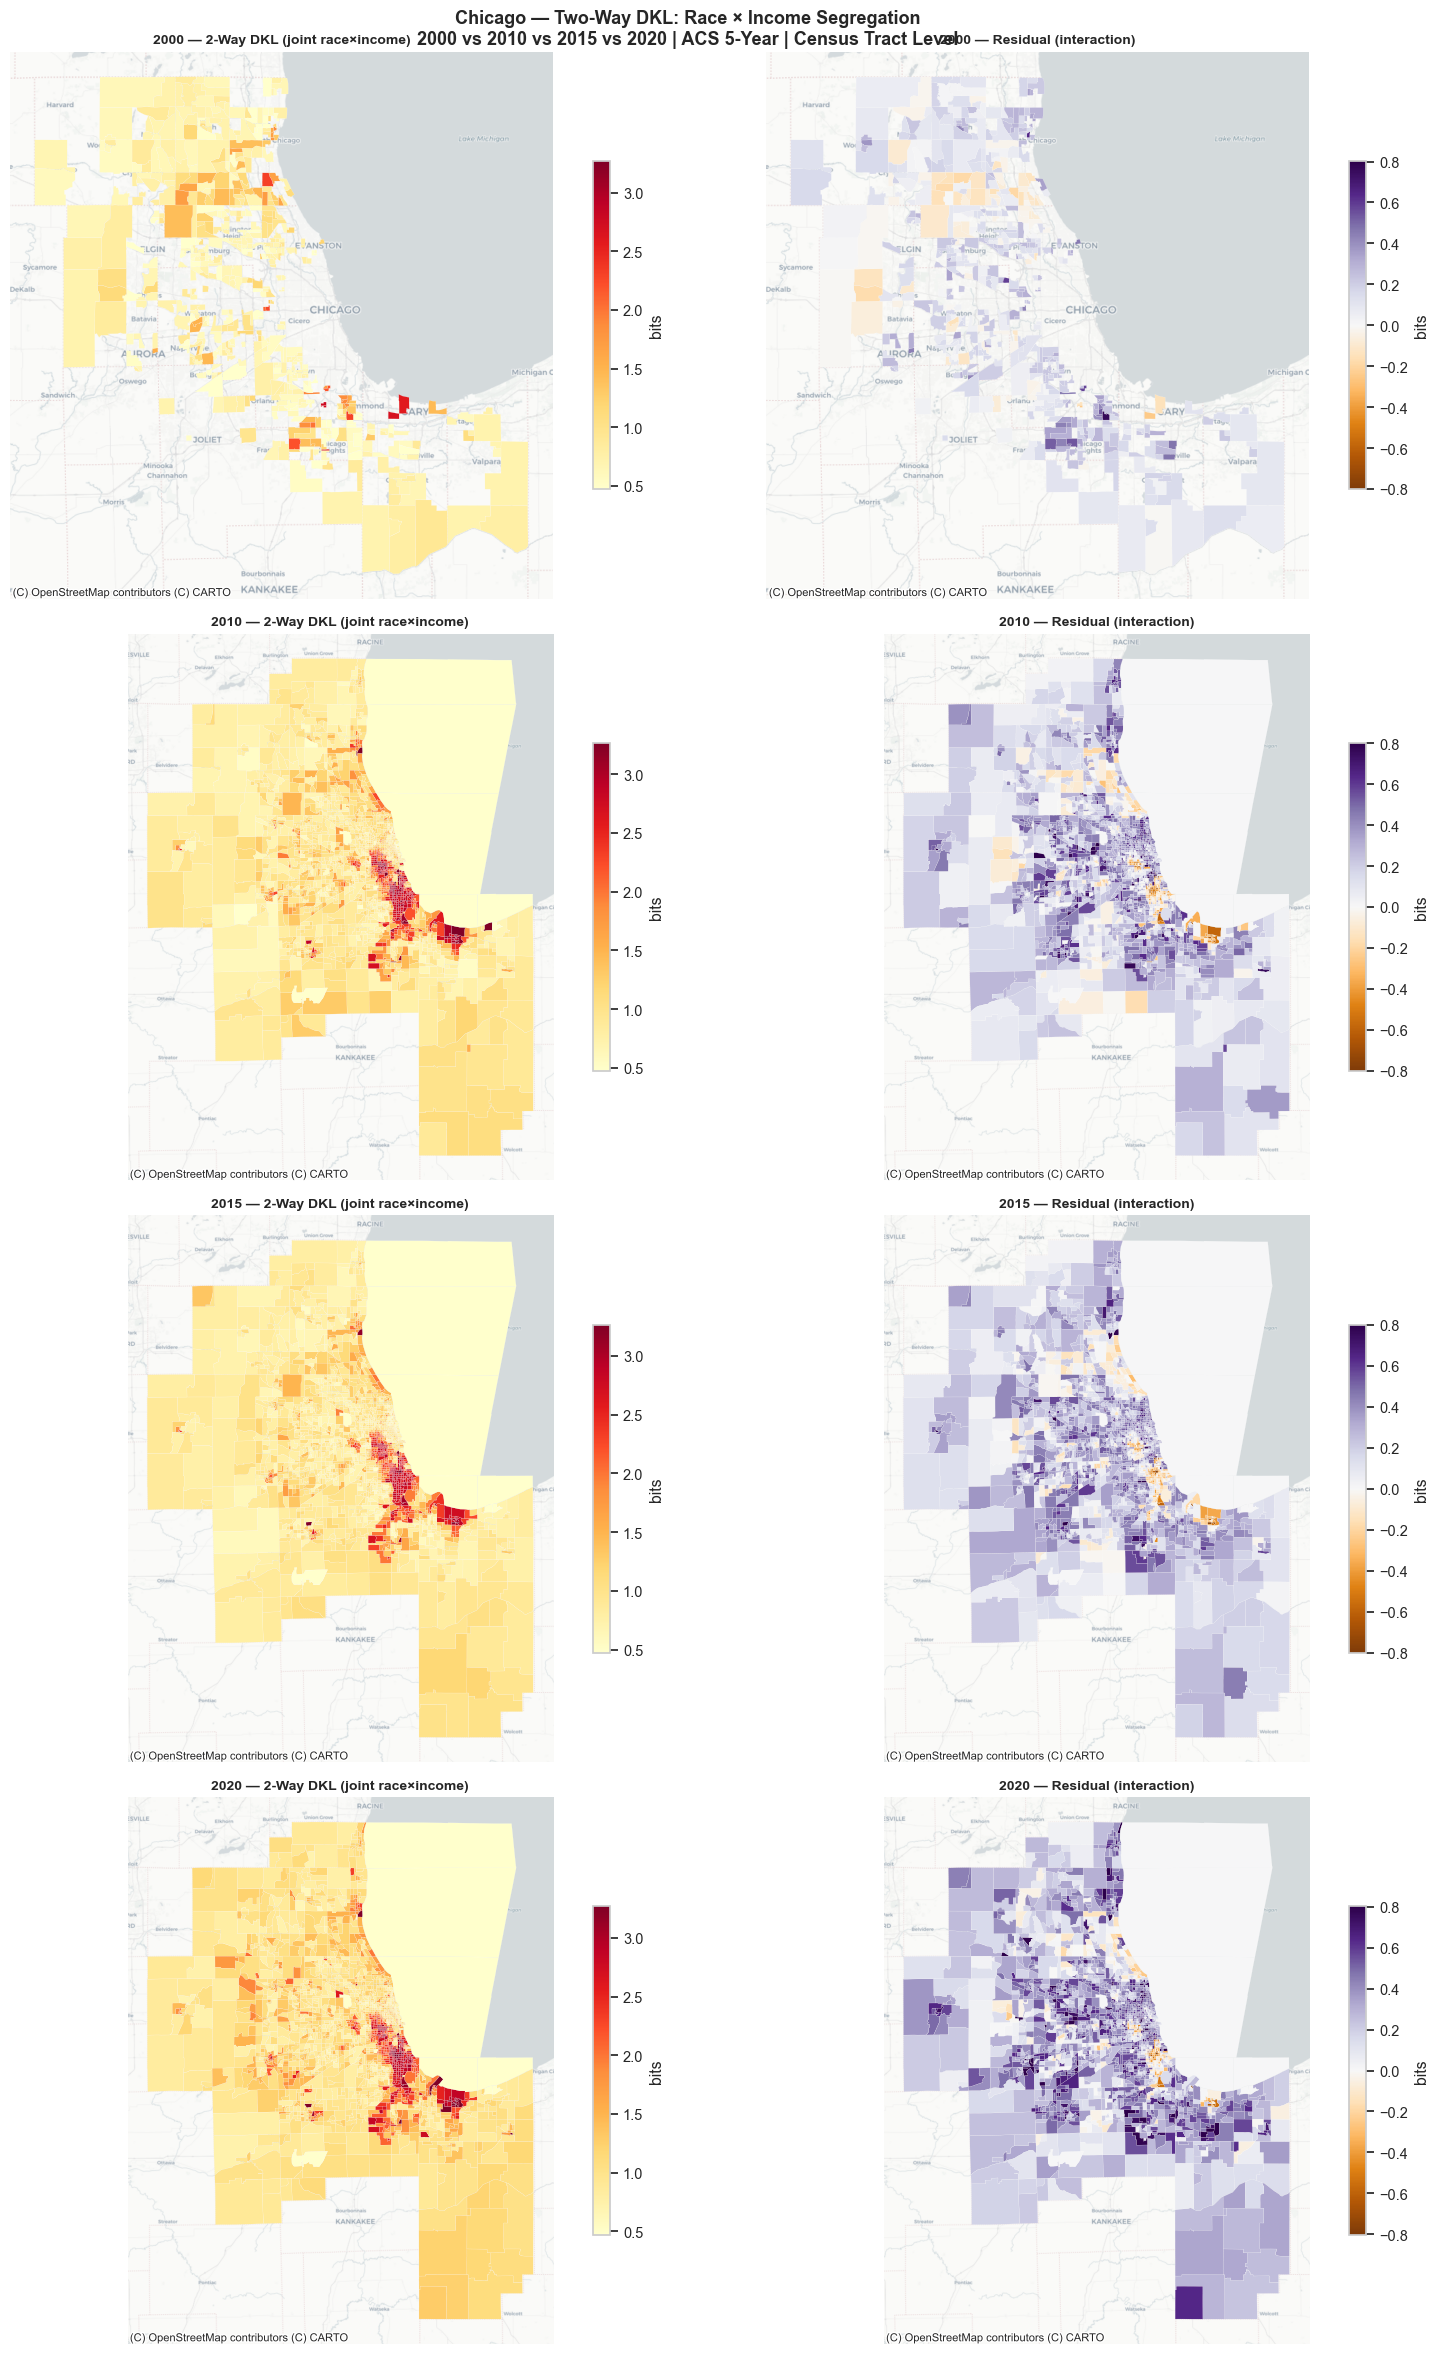

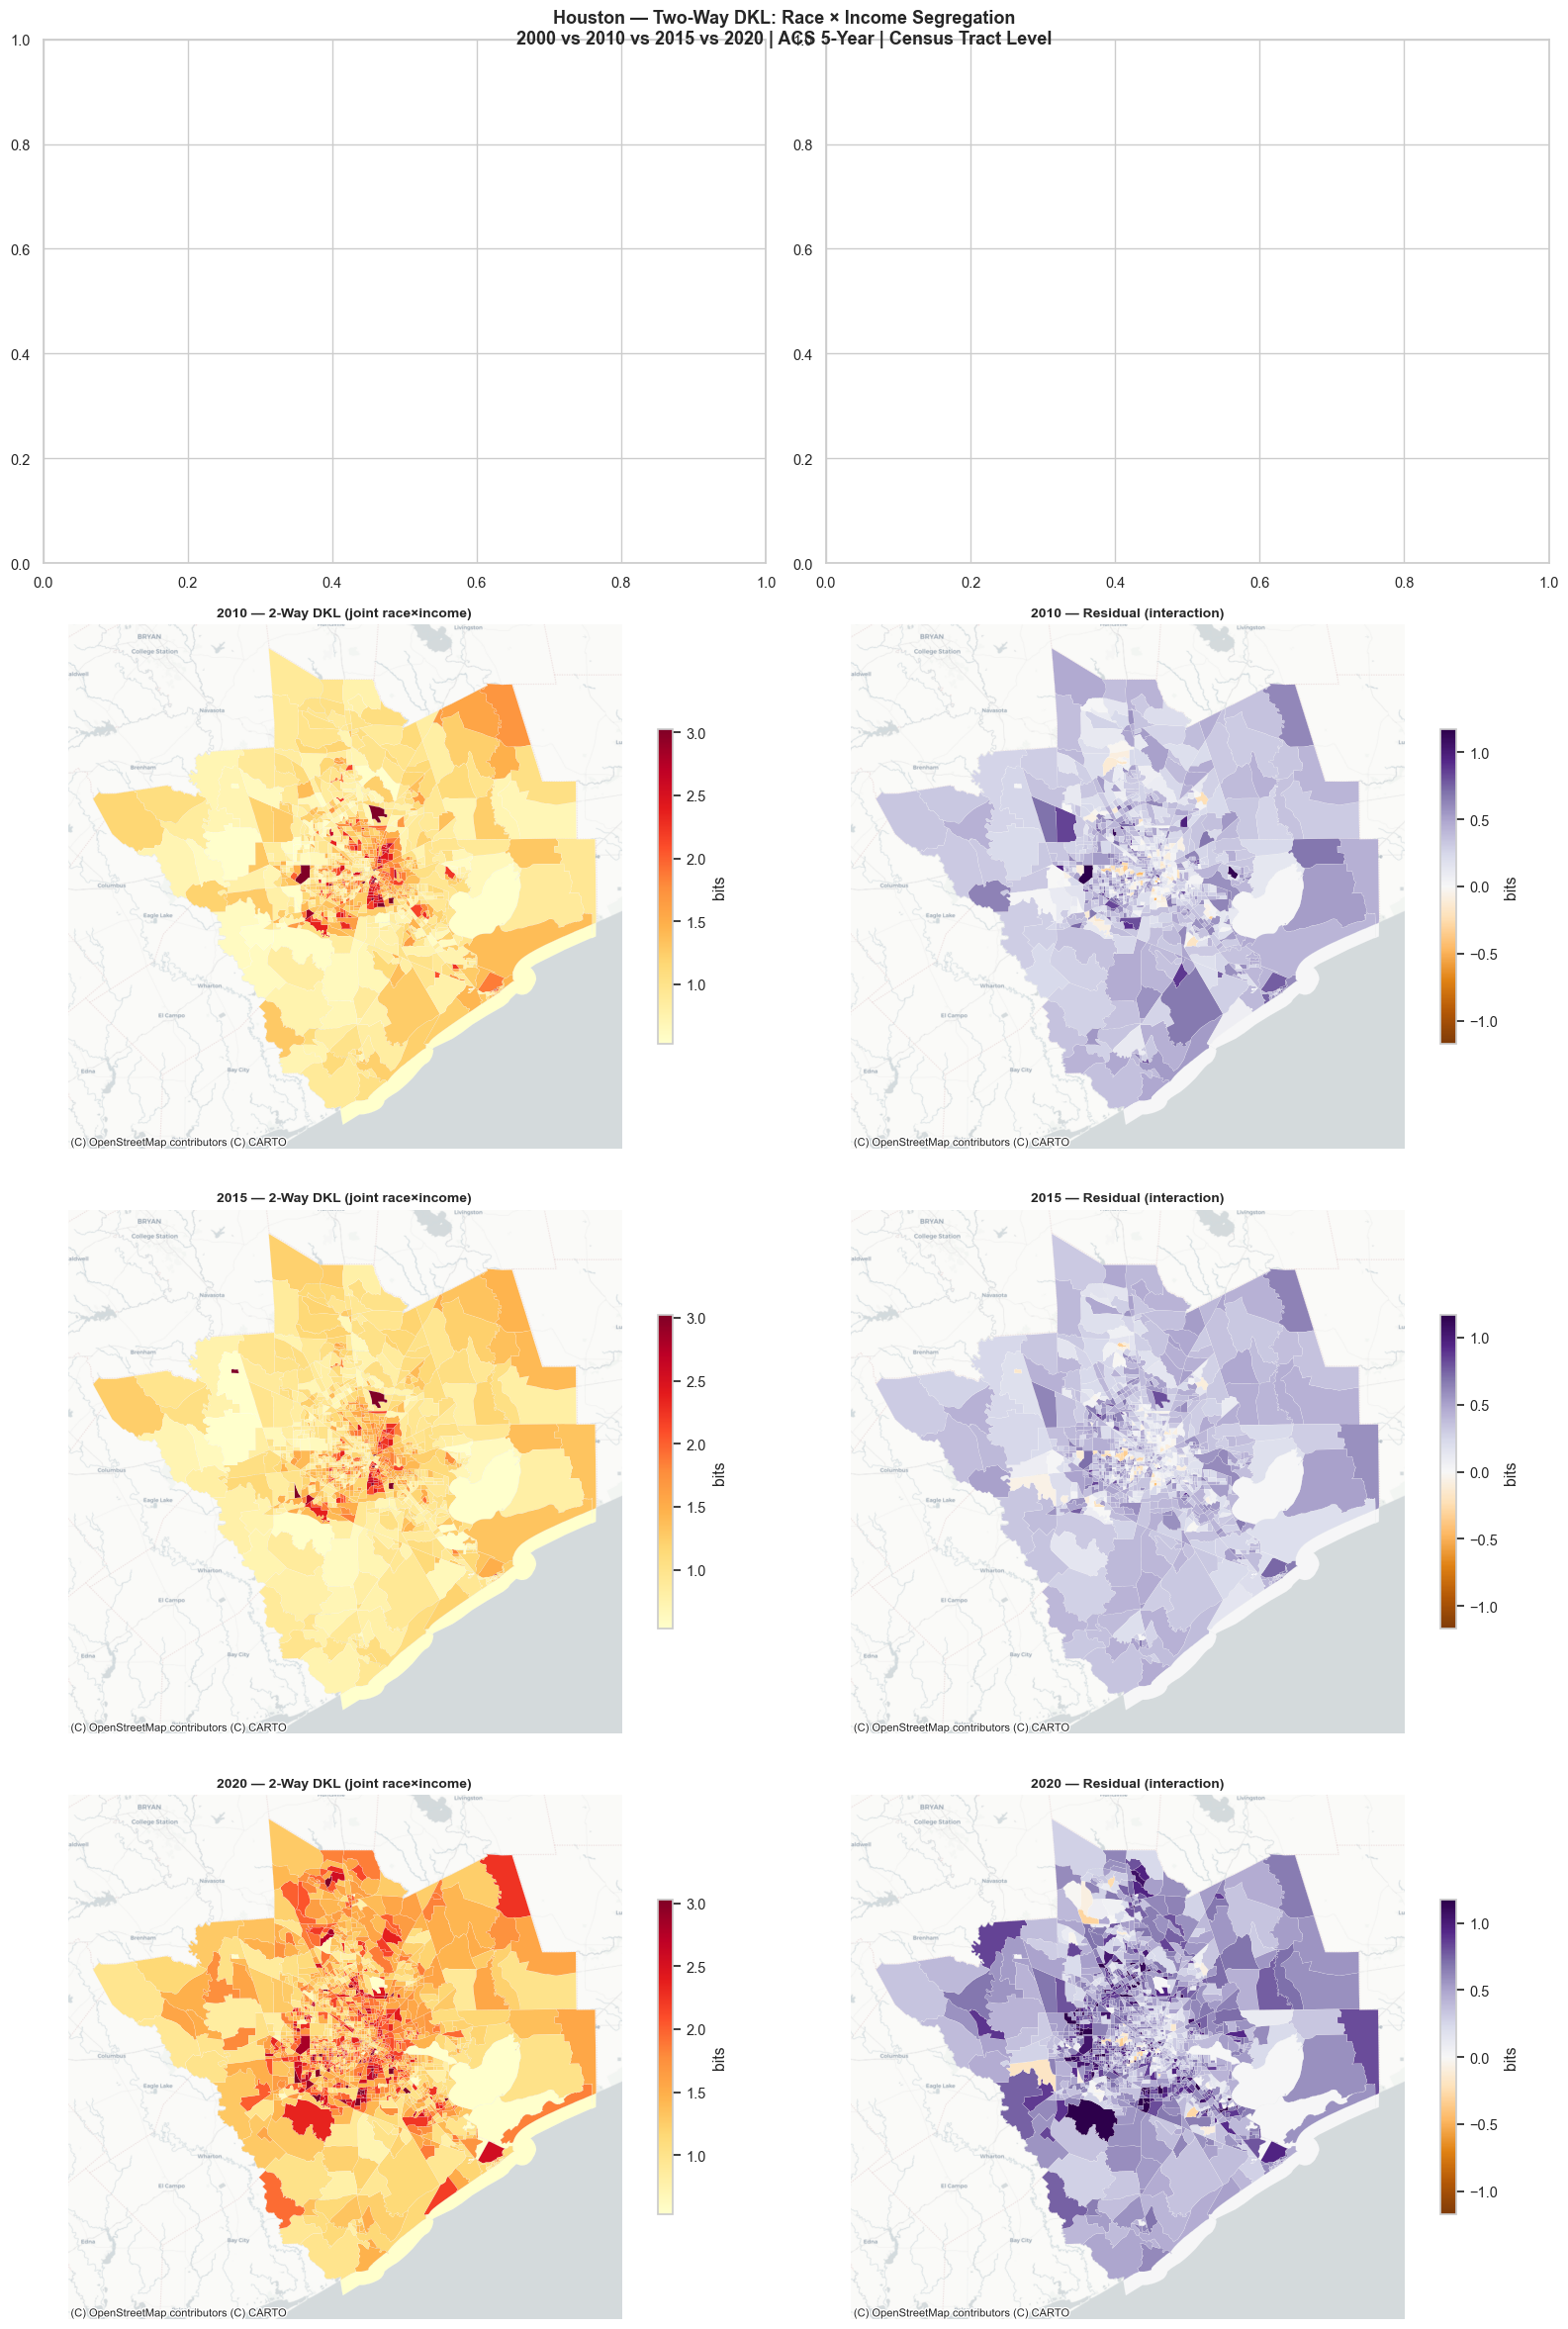

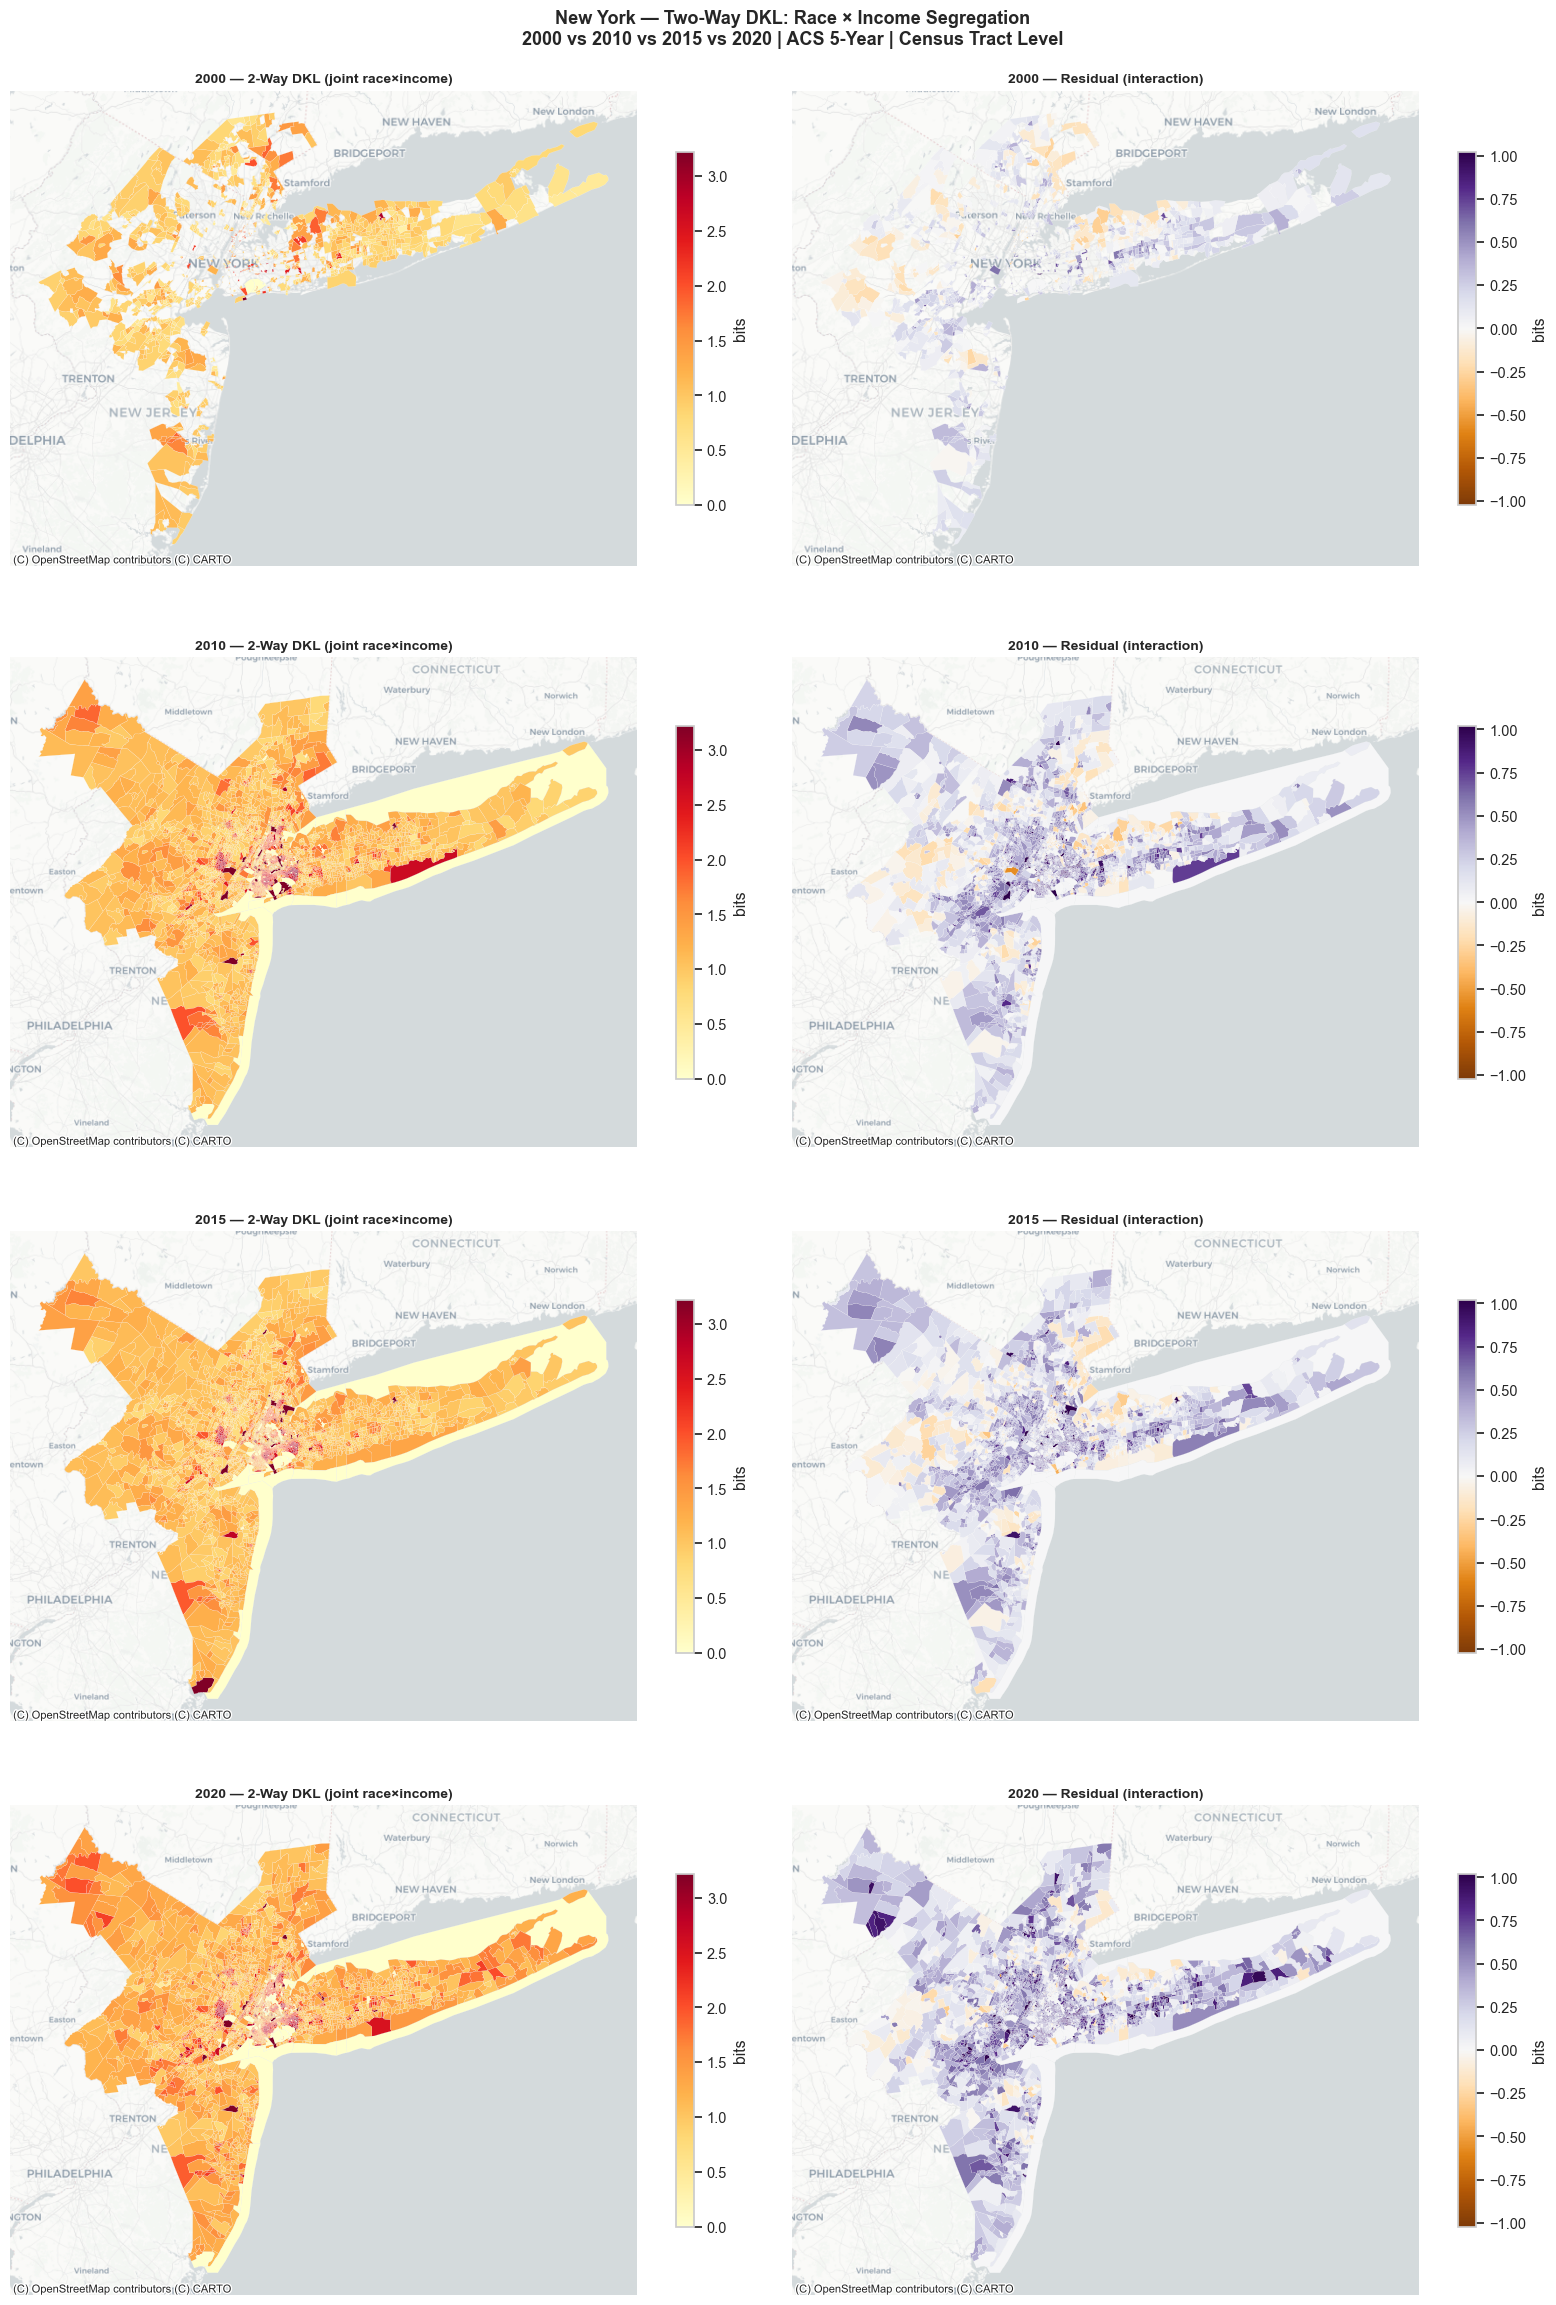

In [15]:
# ── Choropleth: n_years × 2 grid per city (row = year, col = metric) ──────────

COLS    = ['dkl_2way', 'residual']
CTITLES = ['2-Way DKL (joint race×income)', 'Residual (interaction)']
CMAPS   = ['YlOrRd', 'PuOr']

for city in cities_list:
    # Build geo cache and shared colour scales across all years
    geo_cache = {}
    for year in YEARS:
        tdkl = tract_dkl_all[
            (tract_dkl_all['year'] == year) & (tract_dkl_all['city_label'] == city)
        ]
        geo = tracts_by_year[year].merge(
            tdkl[['tract_fips', 'dkl_2way', 'residual']],
            left_on='geoid', right_on='tract_fips', how='inner'
        ).to_crs('EPSG:3857')
        geo_cache[year] = geo

    shared = {}
    for col in COLS:
        all_vals = pd.concat([geo_cache[y][col] for y in YEARS if not geo_cache[y].empty])
        vmin = all_vals.quantile(0.01)
        vmax = all_vals.quantile(0.99)
        if col == 'residual':
            bound = max(abs(vmin), abs(vmax))
            vmin, vmax = -bound, bound
        shared[col] = (vmin, vmax)

    n_rows = len(YEARS)
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 6 * n_rows))

    for ri, year in enumerate(YEARS):
        geo = geo_cache[year]
        if geo.empty:
            continue
        for ci, (col, title, cmap) in enumerate(zip(COLS, CTITLES, CMAPS)):
            ax = axes[ri][ci]
            vmin, vmax = shared[col]
            geo.plot(
                column=col, ax=ax, cmap=cmap,
                vmin=vmin, vmax=vmax,
                linewidth=0.1, edgecolor='white',
                legend=True,
                legend_kwds={'label': 'bits', 'shrink': 0.6, 'orientation': 'vertical'},
                missing_kwds={'color': 'lightgrey'},
            )
            try:
                ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom='auto')
            except Exception:
                pass
            ax.set_axis_off()
            ax.set_title(f'{year} — {title}', fontsize=10, fontweight='bold')

    year_str = ' vs '.join(str(y) for y in YEARS)
    fig.suptitle(
        f'{city} — Two-Way DKL: Race × Income Segregation\n'
        f'{year_str} | ACS 5-Year | Census Tract Level',
        fontsize=13, fontweight='bold'
    )
    plt.tight_layout()
    plt.show()